In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [19]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
clinical = CPTAC.get_clinical()

msi_status = clinical['MSI_status']

idx
S001    MSI-H
S002    MSI-H
S003      MSS
S005      MSS
S006      MSS
S007      MSS
S008      MSS
S009      MSS
S010    MSI-H
S011      MSS
S012      MSS
S014    MSI-H
S016      MSS
S017    MSI-H
S018      MSS
S019      MSS
S020      MSS
S021      MSS
S022      MSS
S023      MSS
S024      MSS
S025      MSS
S026      MSS
S027      MSS
S028      MSS
S029      MSS
S030    MSI-H
S031      MSS
S032    MSI-H
S033      MSS
        ...  
S124      NaN
S125      NaN
S126      NaN
S127      NaN
S128      NaN
S129      NaN
S130      NaN
S131      NaN
S132      NaN
S133      NaN
S134      NaN
S135      NaN
S136      NaN
S137      NaN
S138      NaN
S139      NaN
S140      NaN
S141      NaN
S142      NaN
S143      NaN
S144      NaN
S145      NaN
S146      NaN
S147      NaN
S148      NaN
S149      NaN
S150      NaN
S151      NaN
S152      NaN
S153      NaN
Name: MSI_status, Length: 144, dtype: object


## ARID1A

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_l

                  Mutation  ARID1A-S1755  ARID1A-S1184  ARID1A-S1604  \
S001  MSI - Other Mutation       -0.9290      -1.40000      0.097300   
S002      MSI - Truncation       -1.6000      -0.69300     -0.578500   
S003        MSS - Wildtype       -0.5990      -1.05000     -1.010000   
S006        MSS - Wildtype       -0.3130       0.33300     -0.317000   
S007        MSS - Wildtype        0.5190       0.22700     -0.012316   
S008      MSS - Truncation        0.0551      -0.01450     -0.026000   
S010        MSI - Wildtype        0.8290       0.79700      0.459000   
S011        MSS - Wildtype        0.0606       0.00000      0.083200   
S012      MSS - Truncation       -0.8140      -0.94800     -1.160000   
S014      MSI - Truncation       -1.5100      -1.12000     -1.501500   
S017        MSI - Wildtype        0.4580       0.02530     -0.070900   
S018      MSS - Truncation        0.2950      -0.18800      0.561000   
S019      MSS - Truncation       -0.1880      -0.25000     -0.40

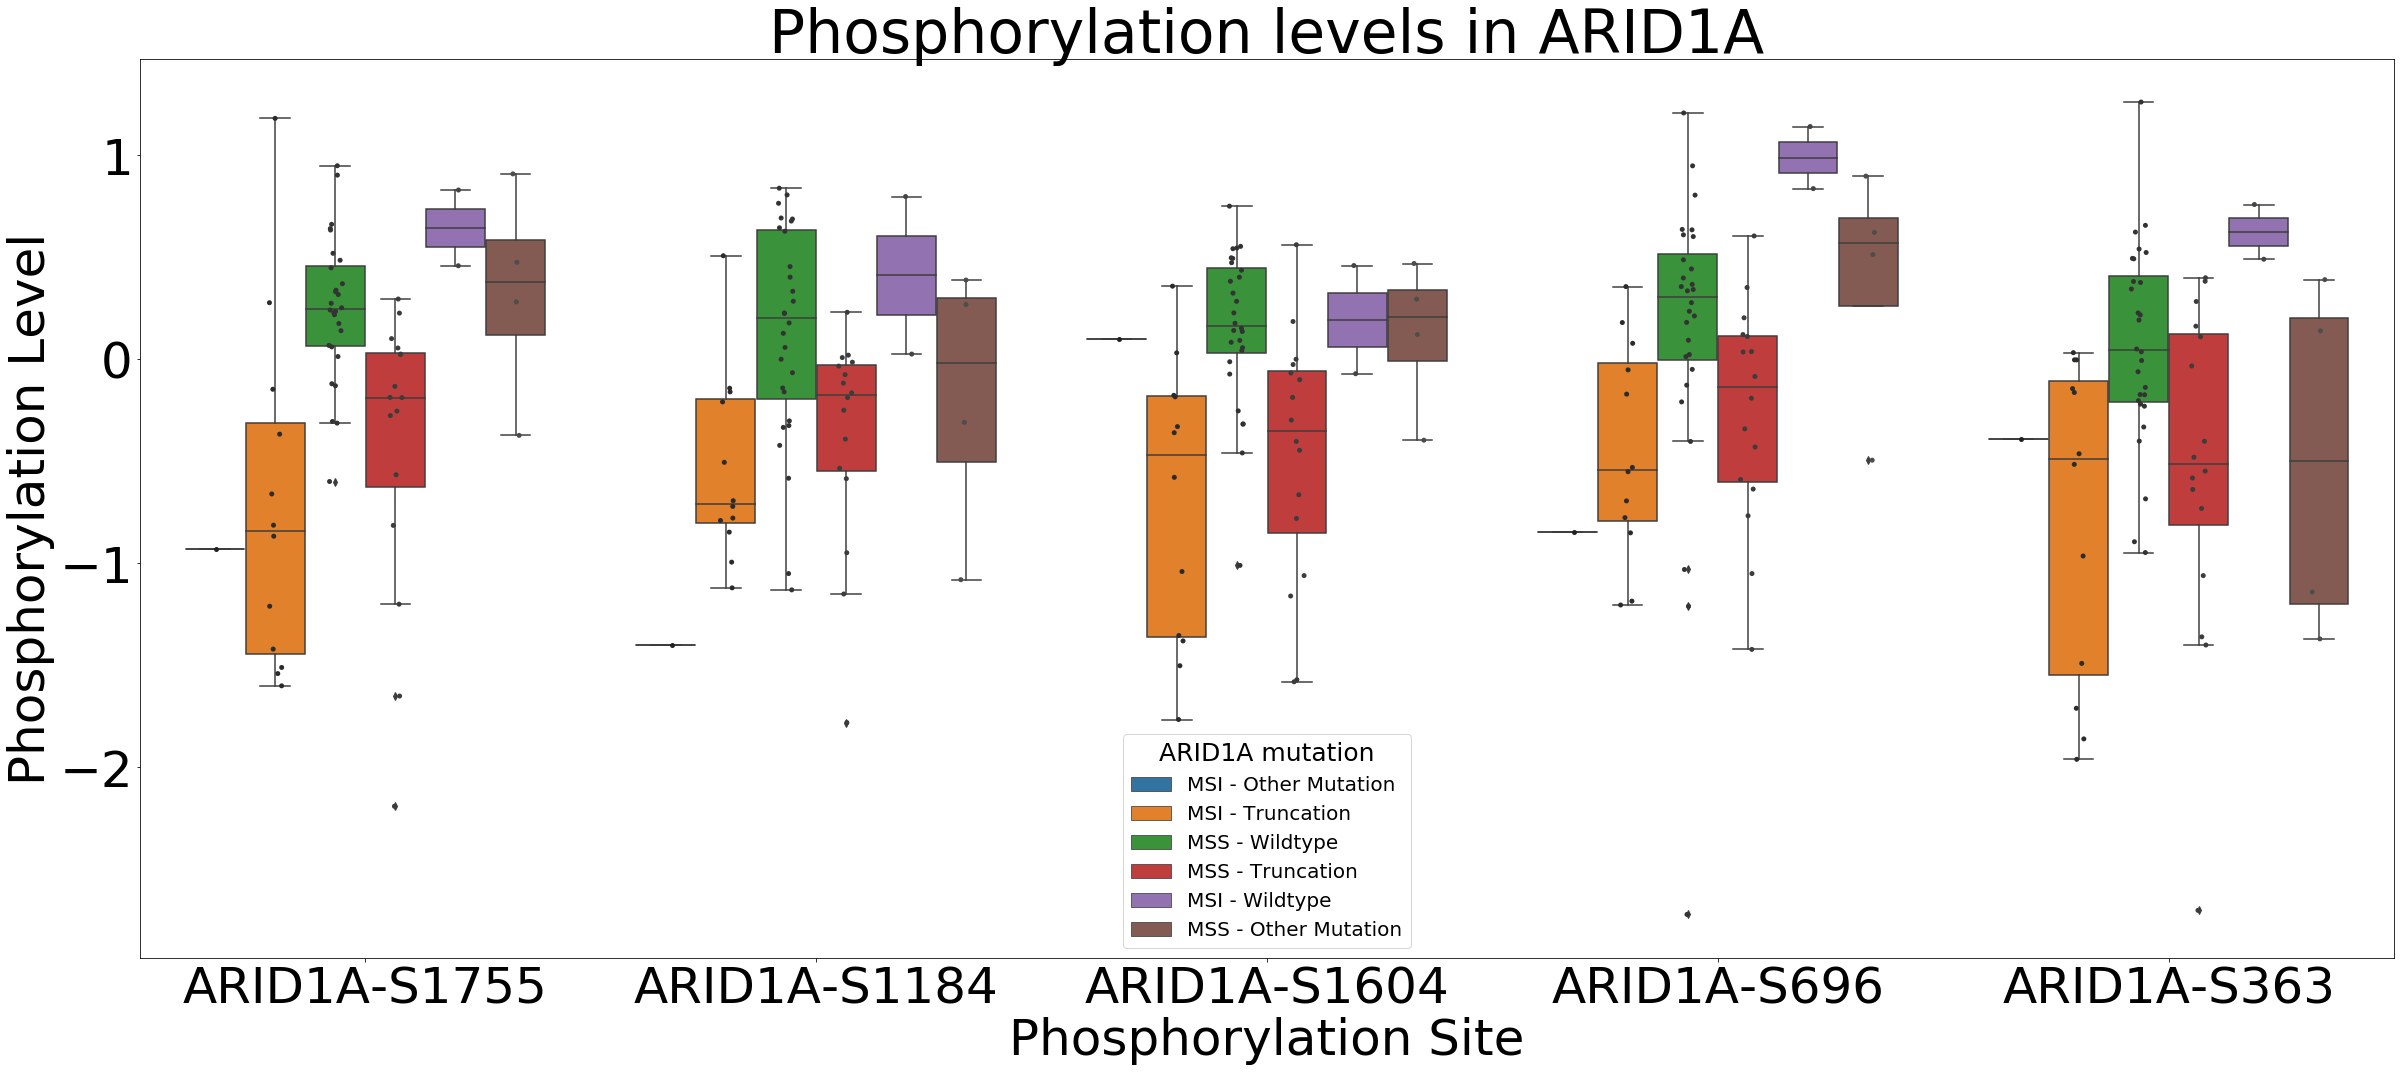

In [24]:
gene = 'ARID1A'
prot = 'ARID1A'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf.dropna(axis=0)


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

print(plotdf)
plotdf = plotdf.drop('MSI Status', axis =1 )

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:6],labels[0:6],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## AHNAK

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


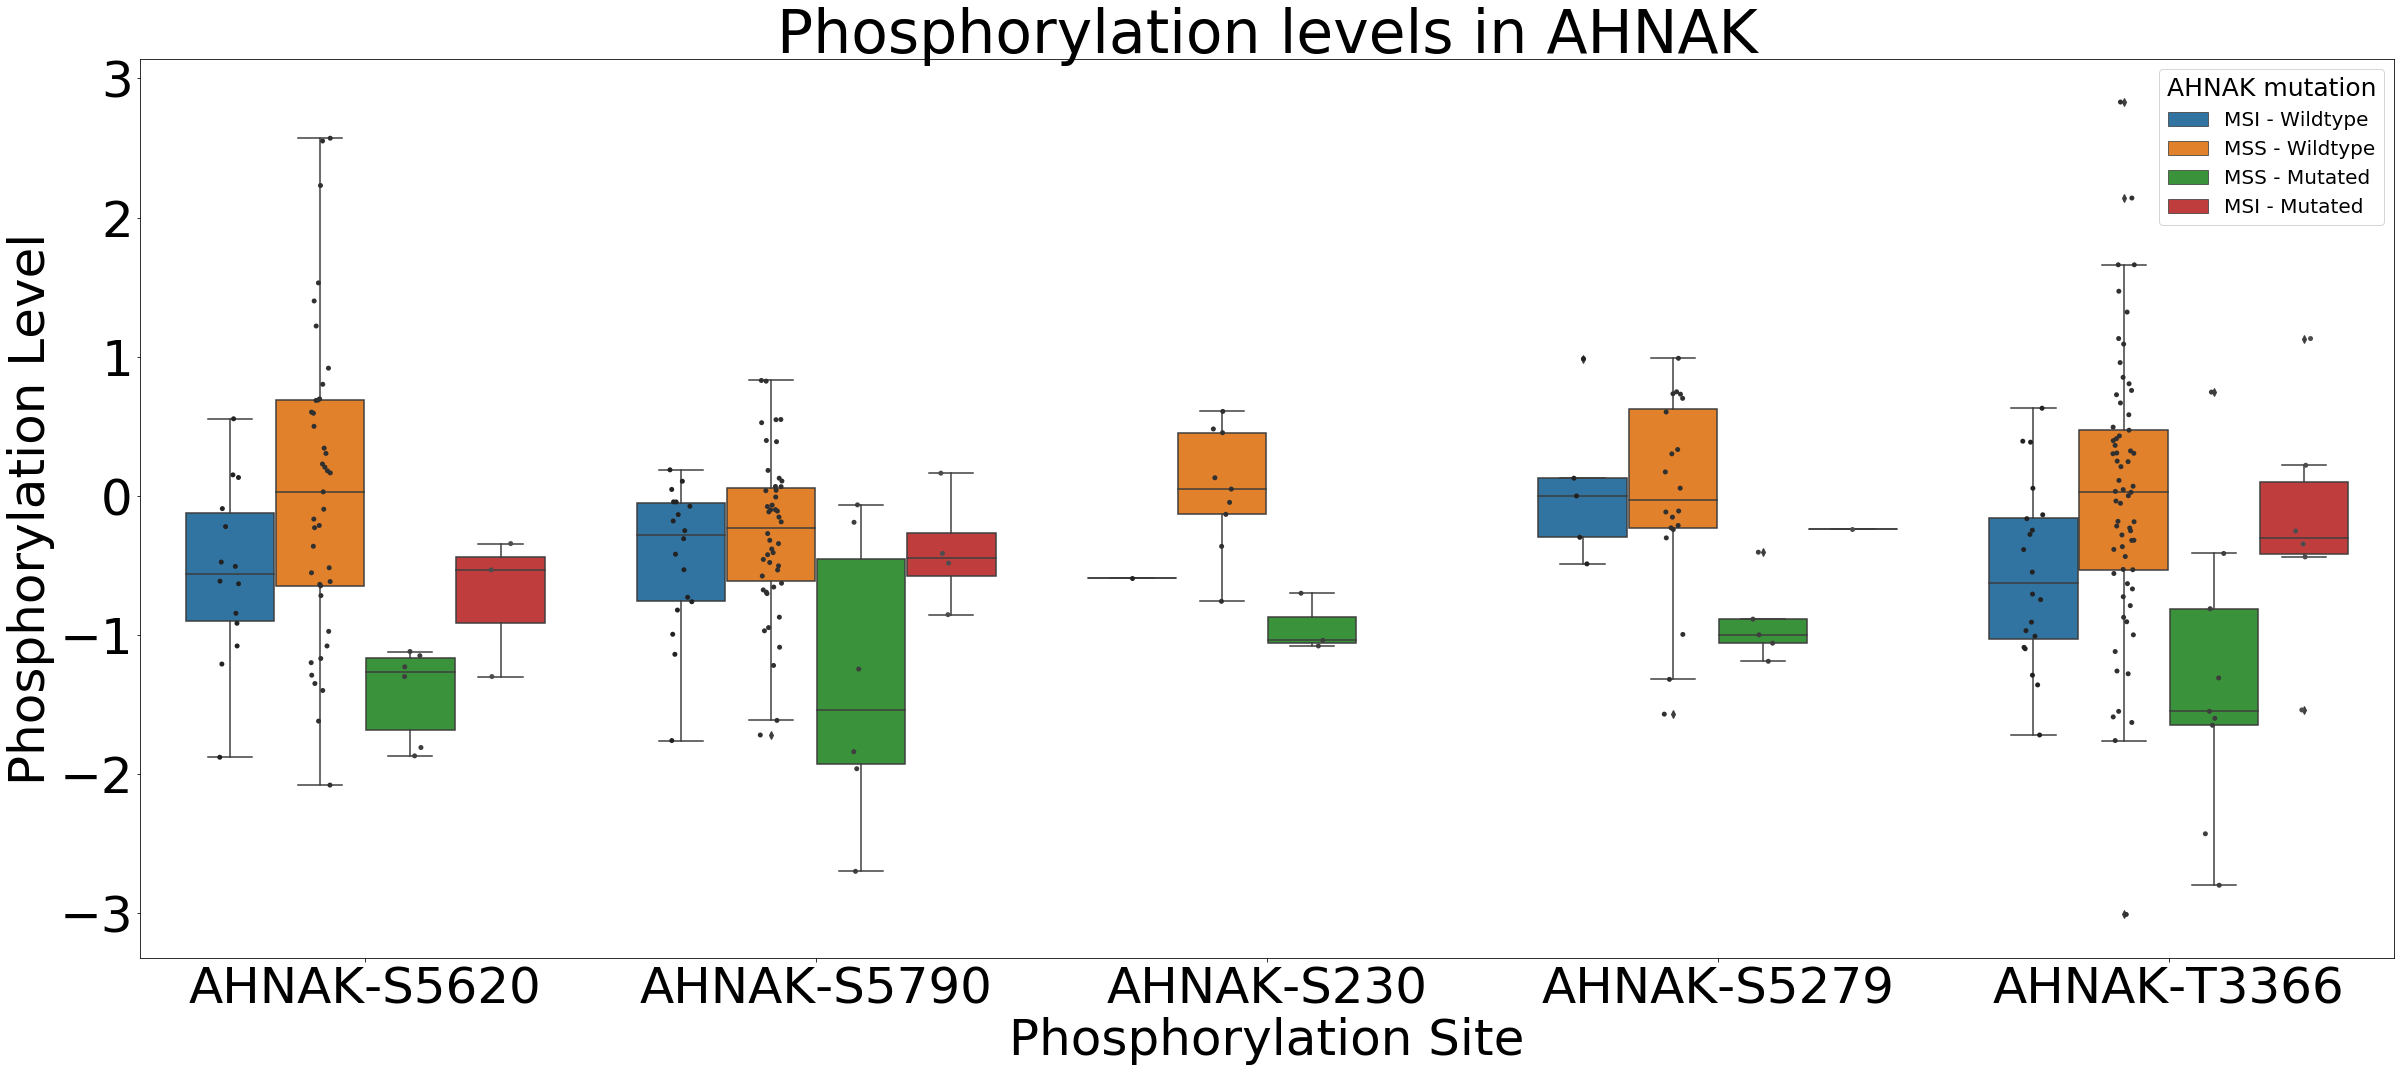

In [12]:
gene = 'AHNAK'
prot = 'AHNAK'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)
    
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf['MSI Status']= msi_status


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Mutated')
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Mutated')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')
        
plotdf = plotdf.drop('MSI Status', axis = 1)
#print(plotdf)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## KMT2D

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


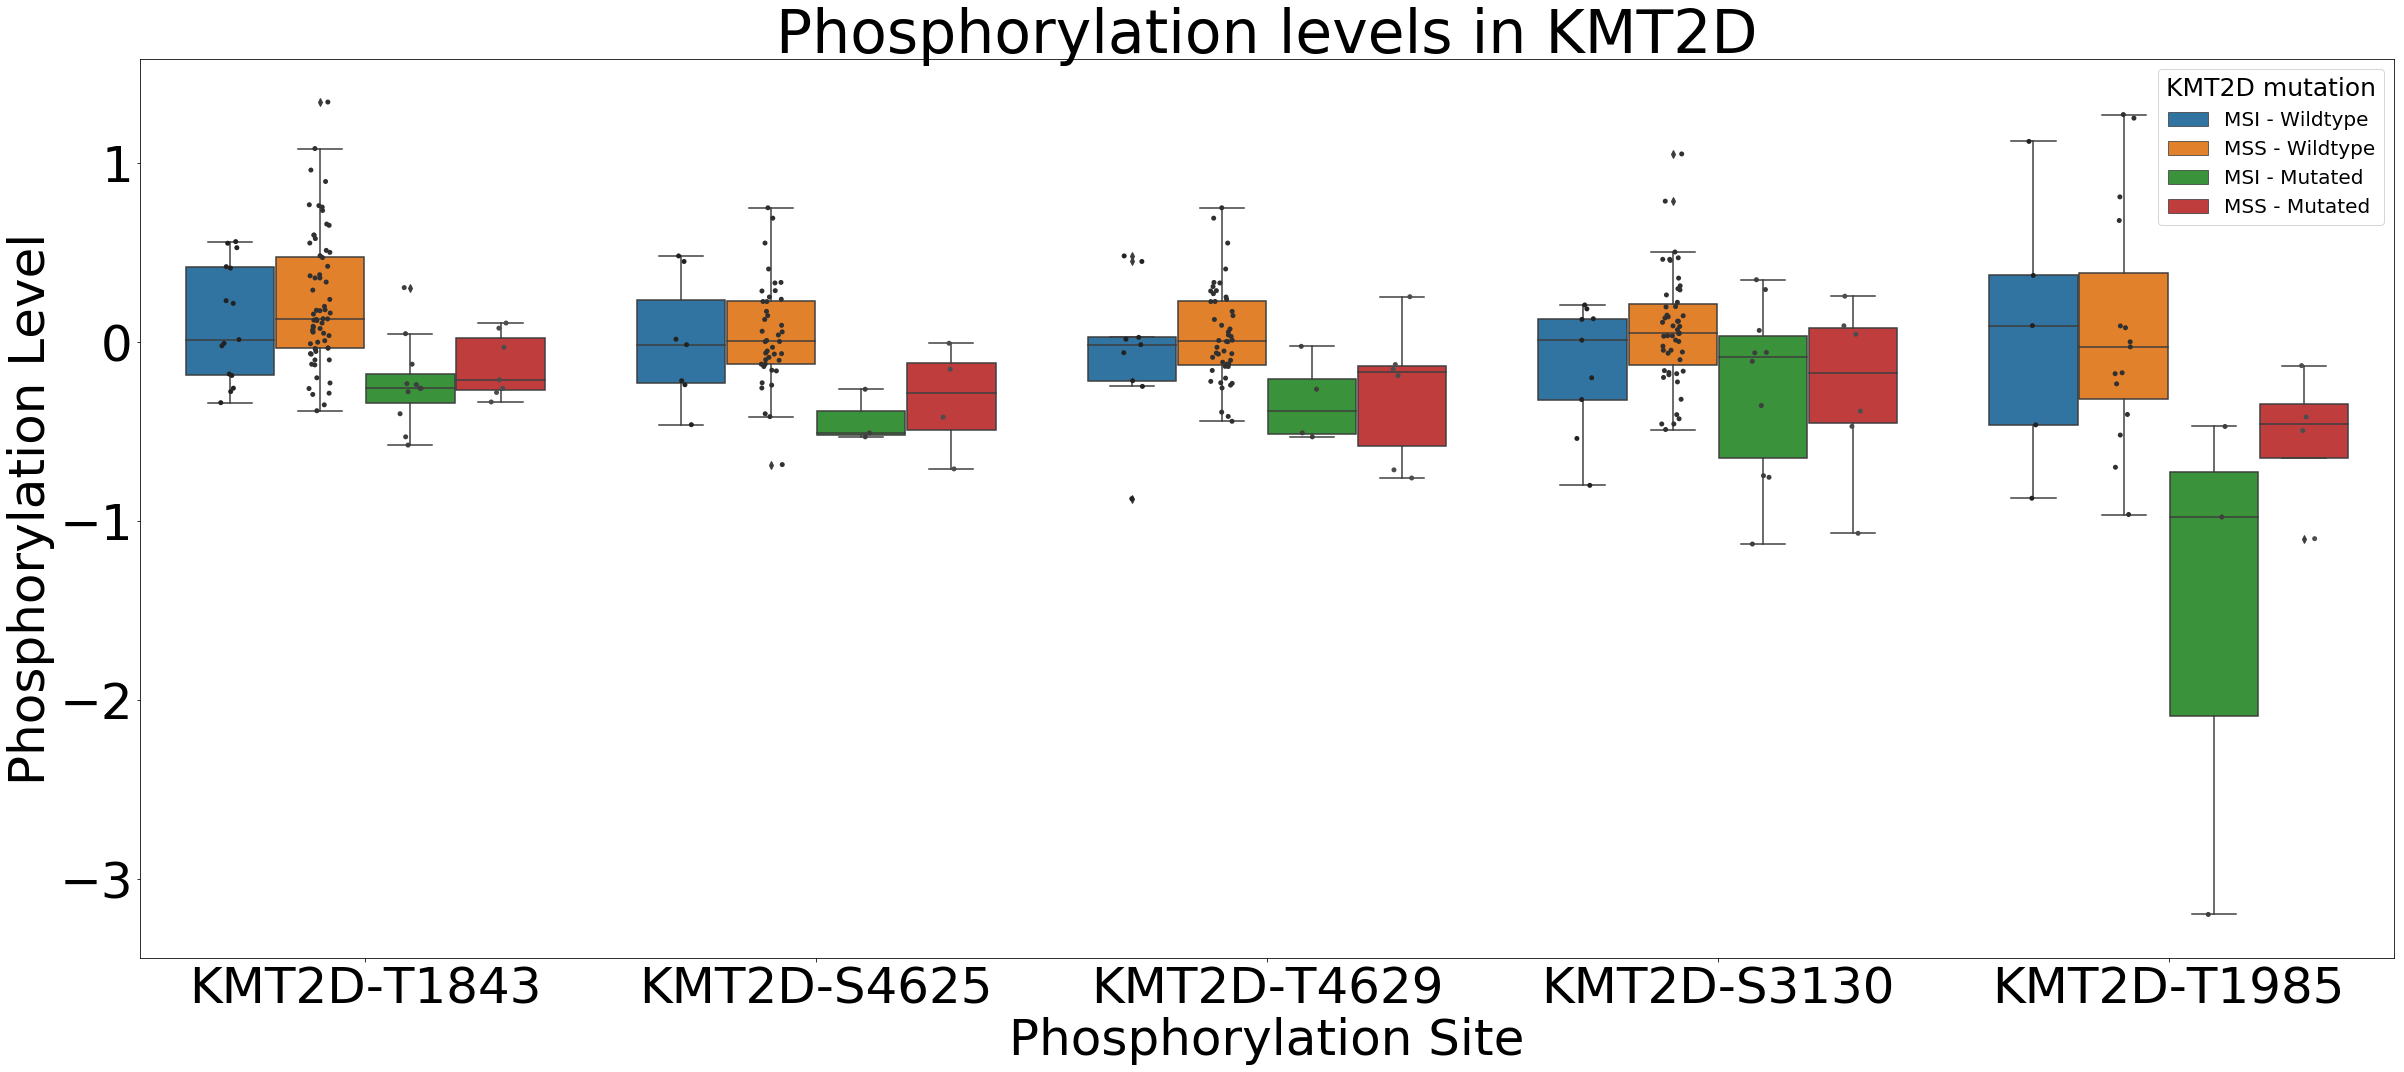

In [13]:
gene = 'KMT2D'
prot = 'KMT2D'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)
    
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf['MSI Status']= msi_status


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Mutated')
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Mutated')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')
        
plotdf = plotdf.drop('MSI Status', axis = 1)
#print(plotdf)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## FLNA

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


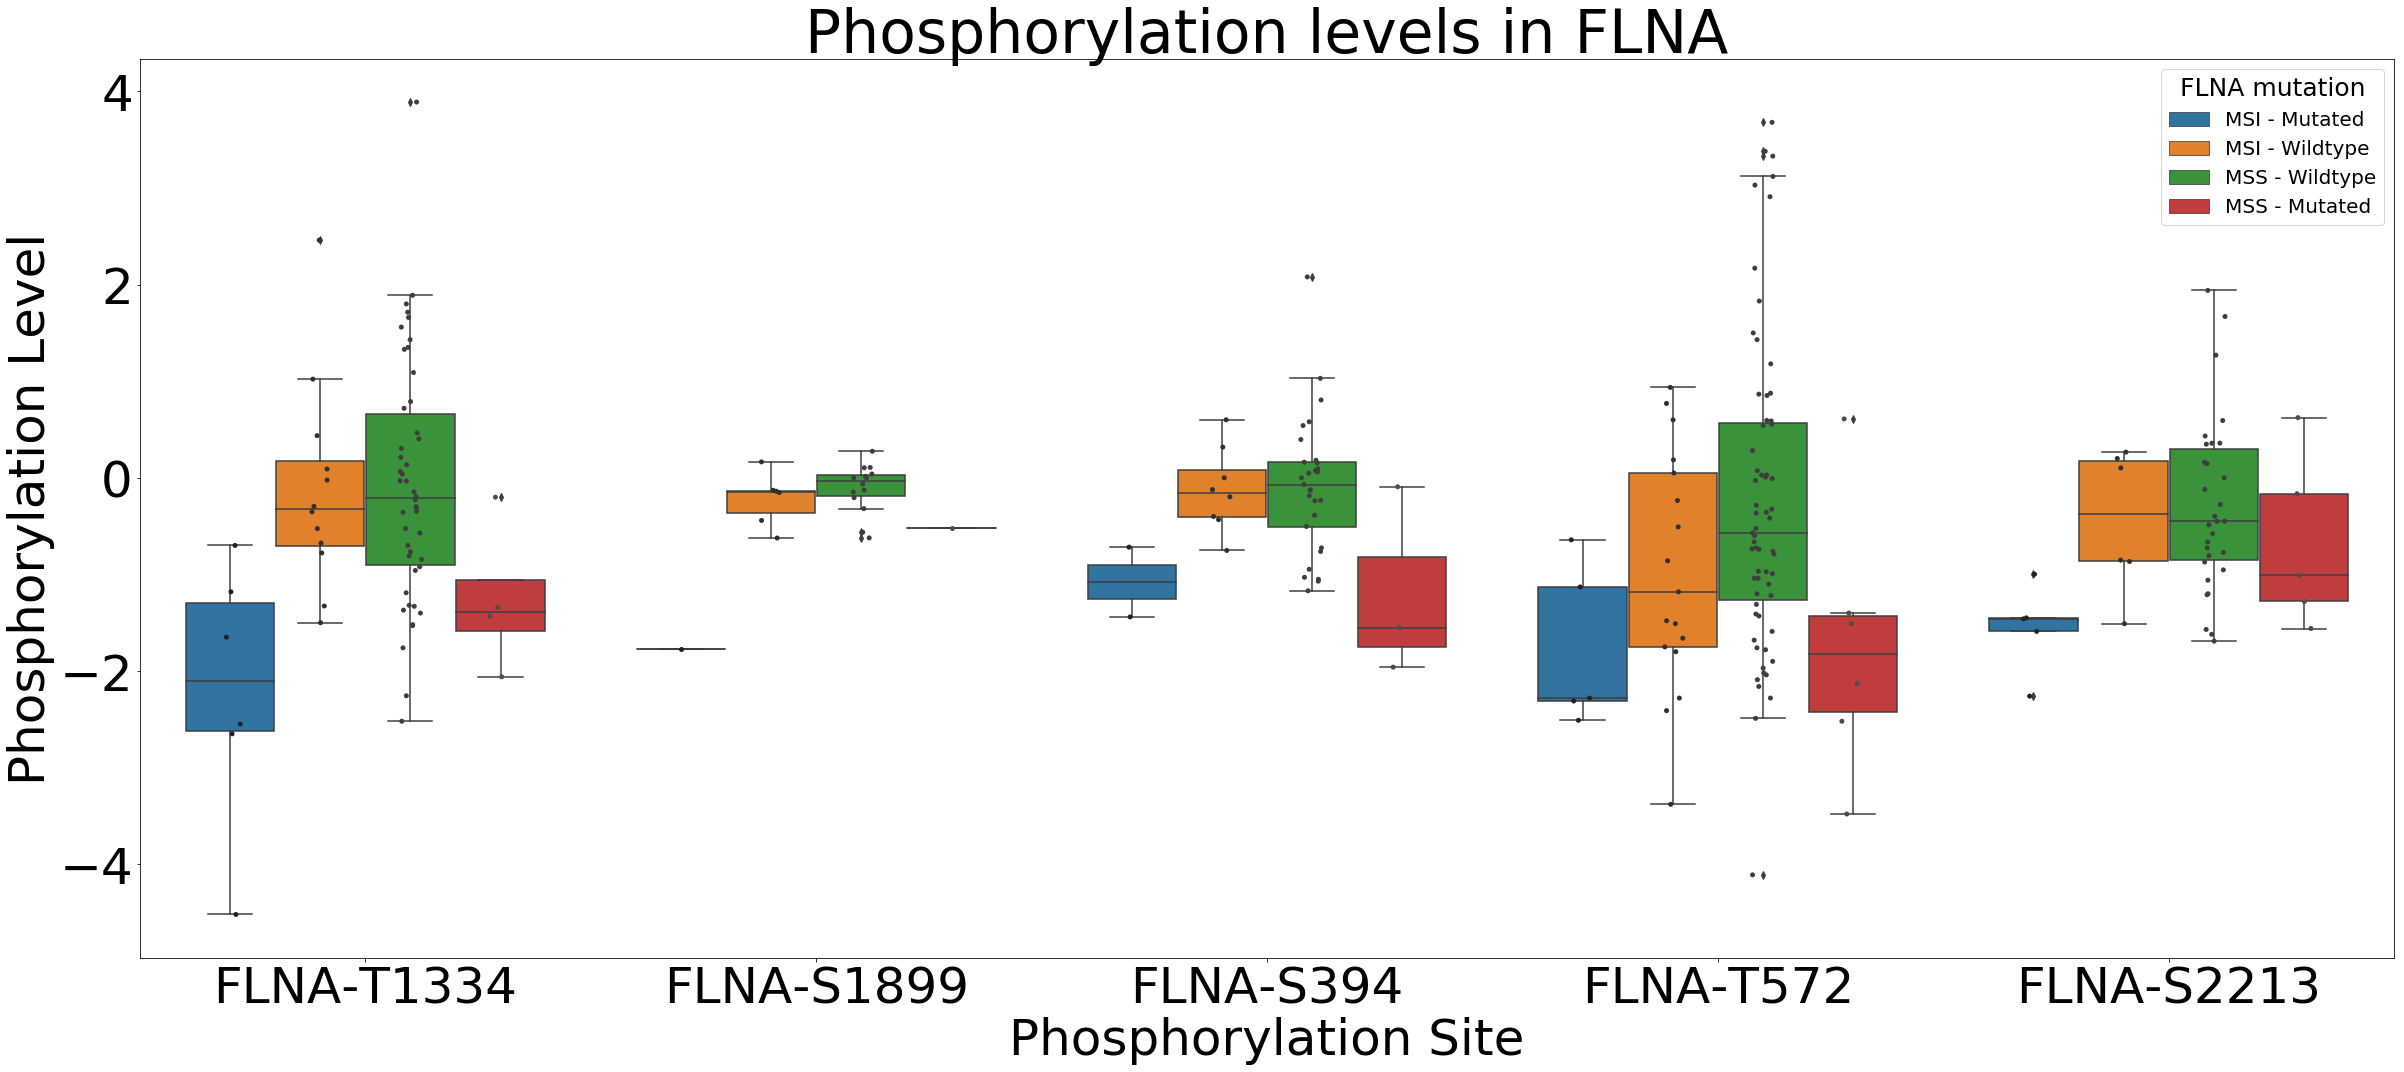

In [14]:
gene = 'FLNA'
prot = 'FLNA'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)
    
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf['MSI Status']= msi_status


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Mutated')
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Mutated')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')
        
plotdf = plotdf.drop('MSI Status', axis = 1)
#print(plotdf)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## ADD3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


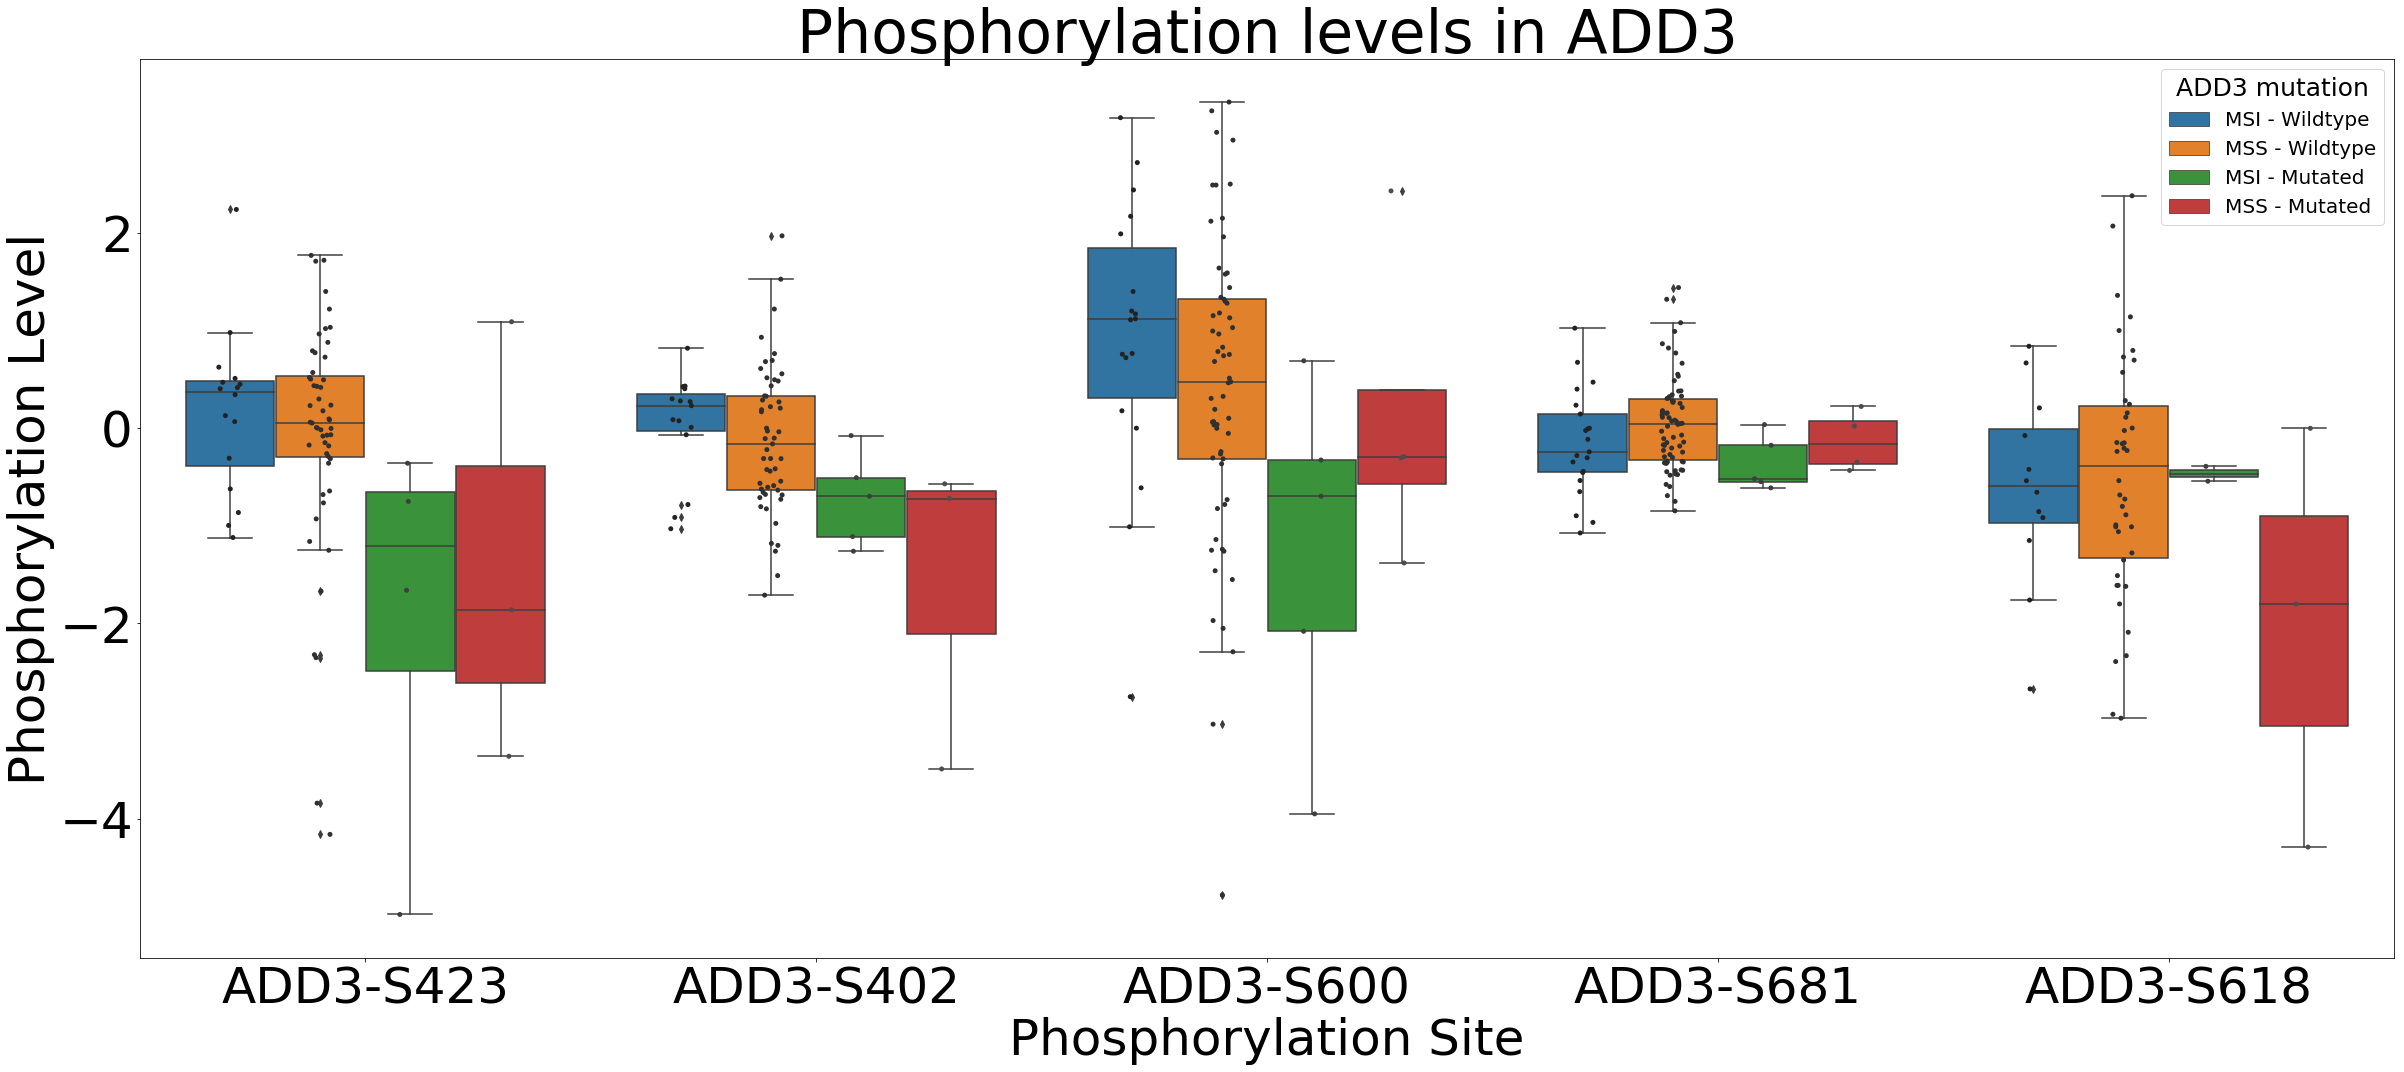

In [15]:
gene = 'ADD3'
prot = 'ADD3'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)
    
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf['MSI Status']= msi_status


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Mutated')
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Mutated')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')
        
plotdf = plotdf.drop('MSI Status', axis = 1)
#print(plotdf)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## CTNNB1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


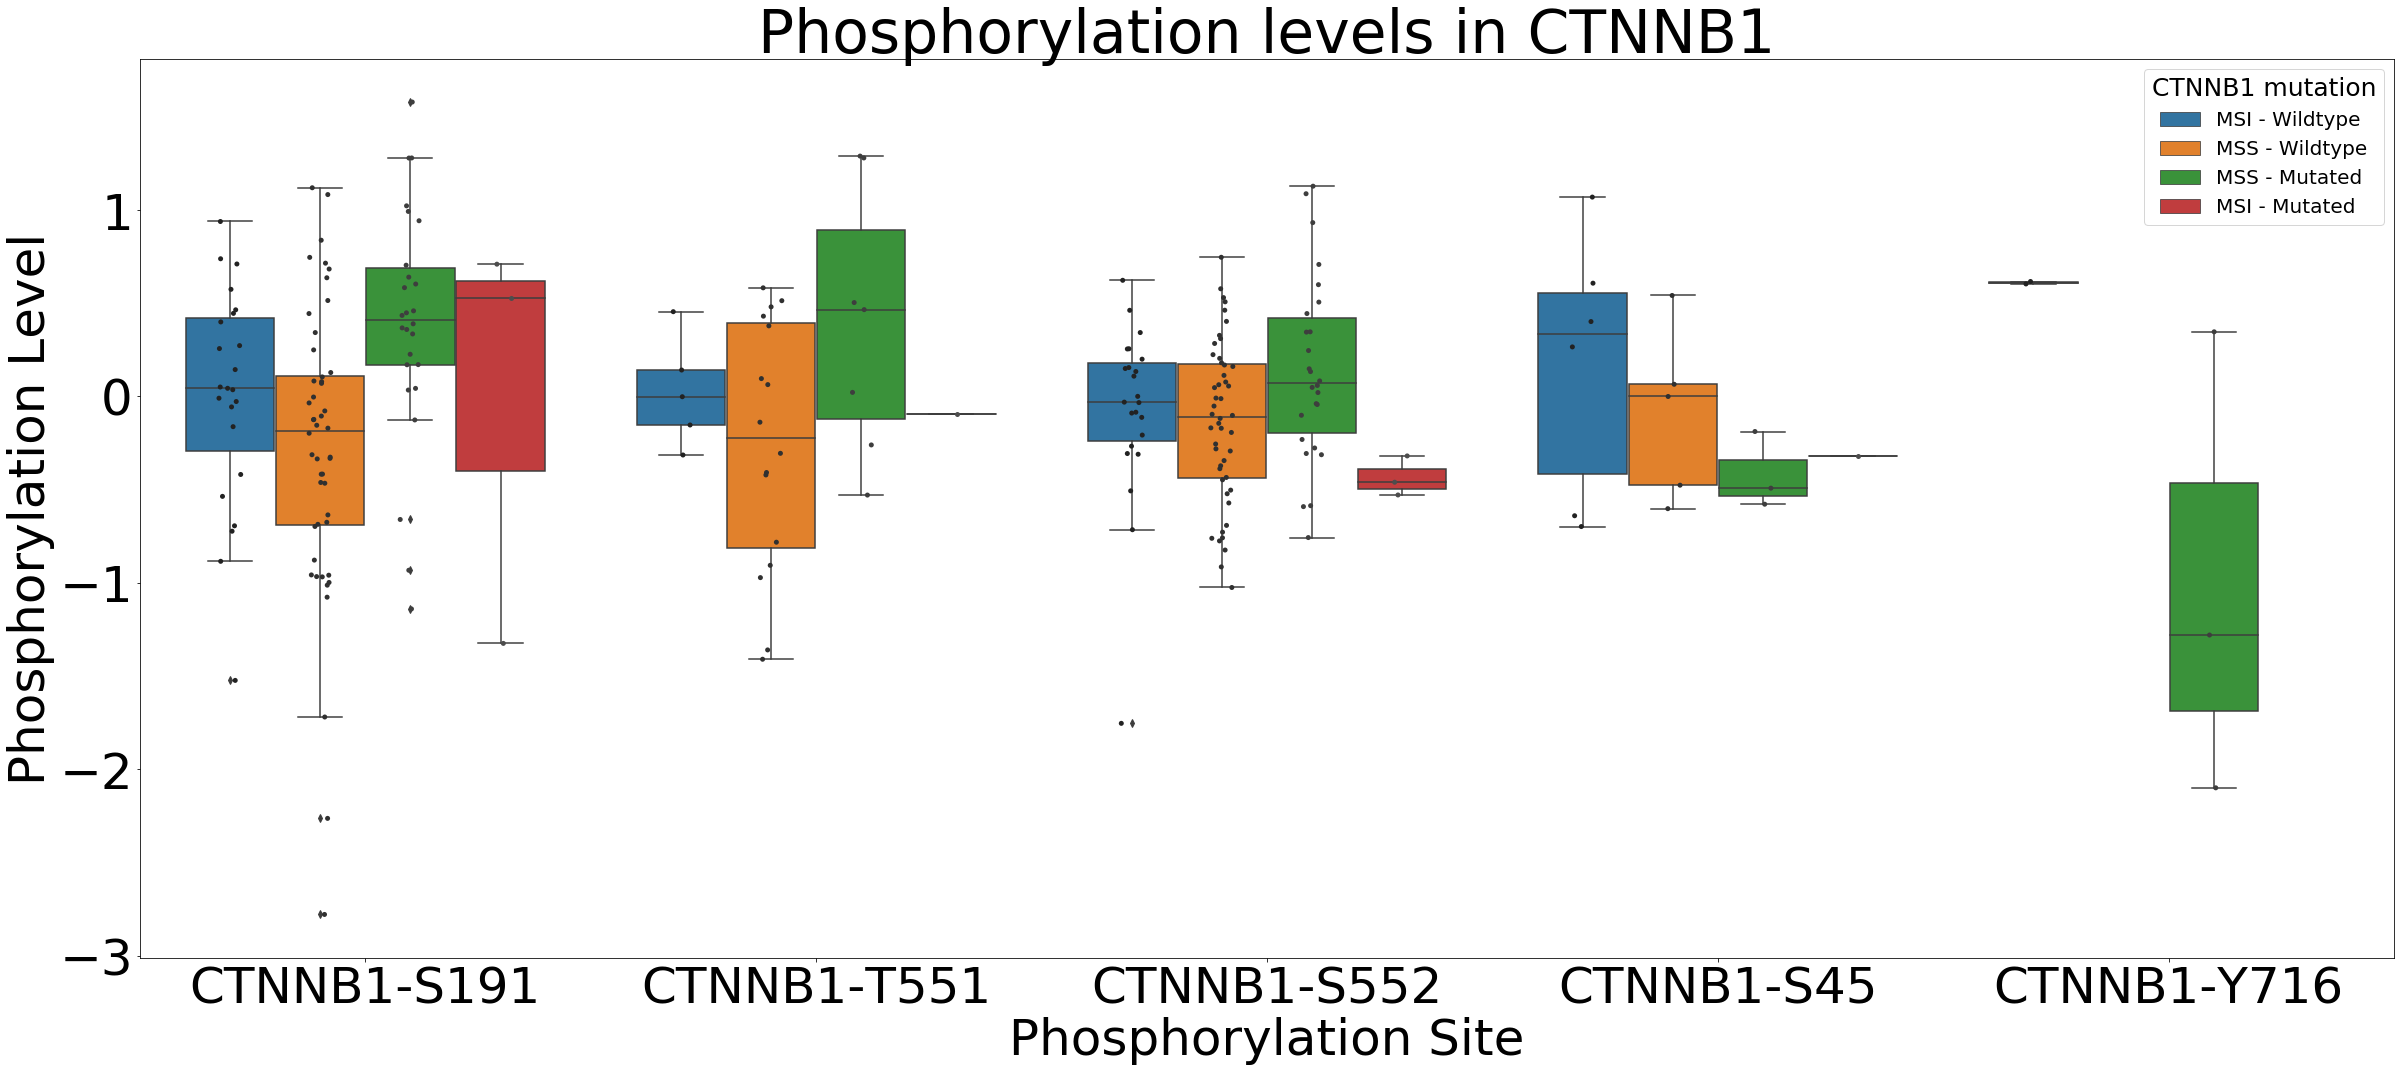

In [16]:
gene = 'CTNNB1'
prot = 'CTNNB1'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
    

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)
    
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

plotdf['MSI Status']= msi_status


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Mutated')
    if row['Mutation'] == 'Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Mutated')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')
        
plotdf = plotdf.drop('MSI Status', axis = 1)
#print(plotdf)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')